# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

***img = cv2.filter2D(image, -1, kernel) and sharpen kernel or embossing***  

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

# Utils

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import skimage.morphology as sk

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

After looking at the data we identified that the images have salt-and-pepper noise applied to them and also just general blurring. After multiple attempts with different parameters and filters, these are the steps we settled on to denoise the images:

**Step 1: Convert the image to RGB format**  
    OpenCV loads images in BGR format, but we prefer need to work in RGB format for visualization and processing.  

**Step 2: Apply Median Filter**  
The median filter is particularly effective at removing salt and pepper noise.  

**Step 3: Apply Gaussian Filter**  
This helps reduce remaining noise while preserving image edges to some extent.

**Step 4: Apply Non-Local Means Filter**  
Non-local means denoising is effective for removing noise while retaining fine details in the image.  

**Step 5: Sharpen the image using a Laplacian kernel**  
Sharpening is applied to enhance the edges and details that might have been softened by the previous smoothing filters. The laplacian kernel used here emphasizes the differences between adjacent pixels.



In [ ]:
laplacian_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

In [ ]:
def denoise_image(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.medianBlur(img, 5)
  img = cv2.GaussianBlur(img, (5,5), 1)
  img = cv2.fastNlMeansDenoisingColored(img, None, 12, 12, 7, 21)
  img = cv2.filter2D(img, -1, laplacian_kernel)
  return img

In our instance classification pipeline to further filter out false positives (instances with more matches, due to similar writing or design), we used color corelation to identify instances with similar colors.  

First, we convert the image to HSV. In HSV, the Hue is independent from lighting changes (brightness), meaning the same object in different lighting conditions will have similar hue values. This makes the color histogram more robust to changes in illumination.  

Then we create color histograms and compare the correlation between them to filter out images with lower correlation.

In [ ]:
def compute_color_histogram(image, bins=(8, 8, 8)):
    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Compute the histogram and normalize it
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist)

    return hist

In [ ]:
def plot_histogram(hist, title, color_space='HSV'):
    # Plotting the histogram for the three channels
    plt.figure()
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("Frequency")

    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        plt.plot(hist[i], color=color)
    plt.show()

def visualize_histograms(img_query, roi_train):
    # Compute histograms
    hist_query = compute_color_histogram(img_query)
    hist_roi_train = compute_color_histogram(roi_train)

    # Visualize histograms
    plot_histogram(hist_query, "Histogram for Query Image")
    plot_histogram(hist_roi_train, "Histogram for ROI in Train Image")

As it can be observed from the example below, by plotting the color histogram for the instance present in the scene image - with 103 good matches - the query histogram and the ROI histogram (the identified instance region) look quite similar.  

For the second case, if we compare the histograms (with 73 matches between the ROI and query) it is clear that they are very different, so this reference image would not be identified as a posibile instance. In this way, even if we lower the good matches threshold, we can avoid a false positive and the solution can work for all scenes in the same pipeline with the same threshold.

In [ ]:
img_train_color = cv2.imread("/content/dataset/scenes/scene3.png")
img_train_color = denoise_image(img_train_color)

img_query_color_similar = cv2.imread("/content/dataset/models/ref7.png")
img_query_color_similar = denoise_image(img_query_color_similar)

img_query_color_different = cv2.imread("/content/dataset/models/ref3.png")
img_query_color_different = denoise_image(img_query_color_different)


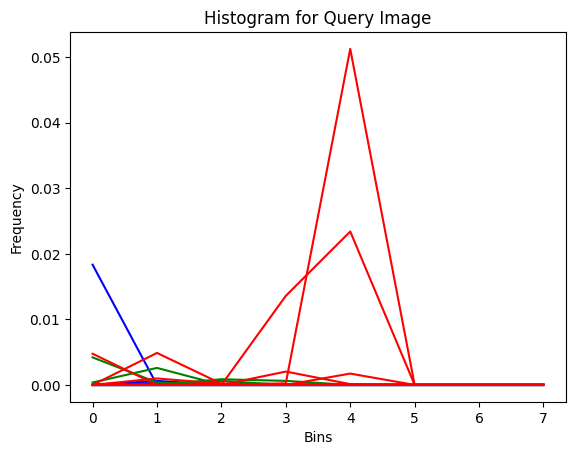

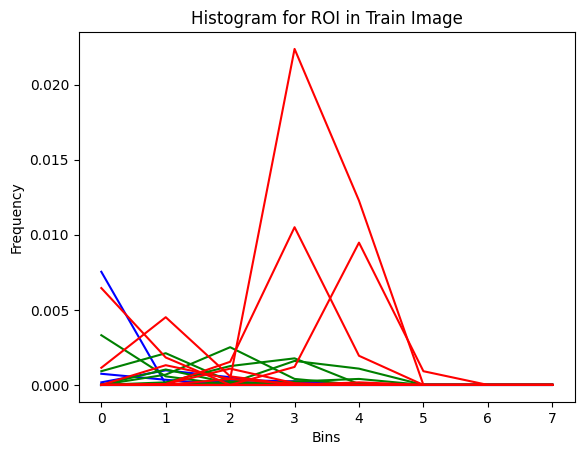

Instance 7 found in scene 3 in position: (889, 461), width: 545px, height: 653px


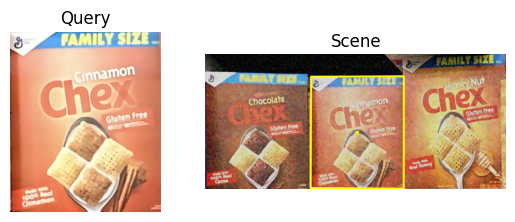

107

In [ ]:
object_retrieve_track_a(img_query_color_similar, img_train_color, 50, 3, 7)

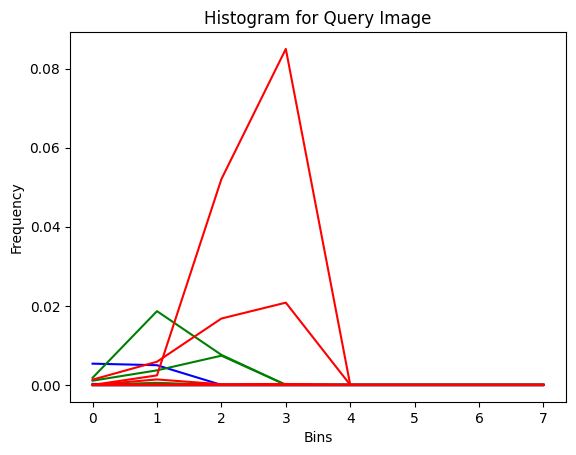

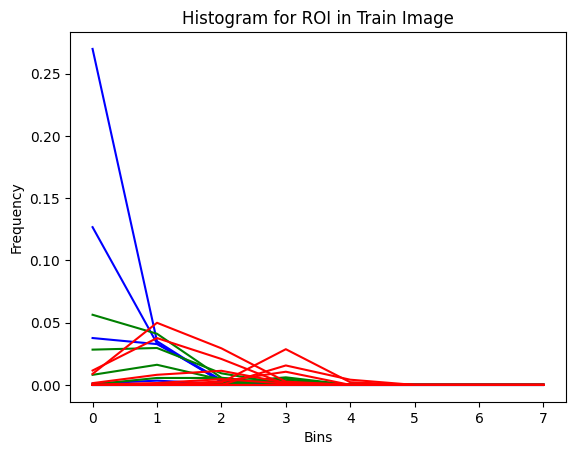

-1

In [ ]:
object_retrieve_track_a(img_query_color_different, img_train_color, 50, 3, 3)

#TrackA

To solve this problem our approach was the following:  

**Step 1.** Denoise the images.  

**Step 2.** Get the keypoints and descriptors with SIFT and Flann Matching.

**Step 3.** Identify the good matches with the Lowe Ratio Test and see if their number passes a general threshold of 50.

**Step 4** Compute the homography and rectangle of the found instance. If the number of good matches is higher than 100, we are sure that the instance we found is good, so proceed to plot and show the result.

**Step 5.** If the number of matches found is lower than 100, we need to do more testing. Compute the Region Of Interest (the rectangle that contains the found instance) and compare the color histograms of the images. If the correlation between the color of the images is low it is a false match. Otherwise, if it is higher than the chosen threshold then we found a match. We can plot and show the results.  

Like this we managed to find all the instances in the scenes and get ***100%*** accuracy.

In [ ]:
def draw_lines_track_a(kp_query, kp_train, img_query, img_train, good, scene_ind, query_ind):
  # Building the corrspondences arrays of good matches
  src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

  # Using RANSAC to estimate a robust homography.
  # It returns the homography M and a mask for the discarded points
  M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

  # Mask of discarded point used in visualization
  matchesMask = mask.ravel().tolist()

  # Corners of the query image
  h, w = img_query.shape[:2]
  pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

  # Projecting the corners into the train image
  dst = cv2.perspectiveTransform(pts, M)

  # Extracting the bounding box
  coordinate = np.int32(dst).reshape(-1, 2)
  x, y, w, h = cv2.boundingRect(coordinate)

  # Extracting the center coordinates
  x_center = x + w//2
  y_center = y + h//2

  # If we found a high enough number of matches => proceed and return results
  # If not => do some extra delimitations by identifying the ROI (Region Of Interest) and comparing the color histograms with the query
  if(len(good) < 100):
      roi_train = img_train[y:y+h, x:x+w]
      if roi_train.size == 0:
          return []

      hist_threshold = 0.2

      # Visualize color histogram, used for test purposes
      #visualize_histograms(img_query, roi_train)

      hist_query = compute_color_histogram(img_query)
      hist_train_roi = compute_color_histogram(roi_train)

      # Compare the color similarity between the images using correlation
      similarity = cv2.compareHist(hist_query, hist_train_roi, cv2.HISTCMP_CORREL)

      if similarity < hist_threshold:
          return []

  print("Instance {} found in scene {} in position: ({}, {}), width: {}px, height: {}px".format(query_ind, scene_ind, x_center, y_center, w, h))

  # Draw the bounding rectangle and the center point of the found query
  img_train_p = img_train.copy()
  img_train_p = cv2.polylines(img_train_p,[np.int32(dst)],True,(255, 255, 0),10, cv2.LINE_AA)
  img_train_p = cv2.circle(img_train_p, (x_center, y_center),10, (255, 255, 0), -1)
  return img_train_p


In [ ]:
def lowe_ratio_test_track_a(matches, min_match_count, kp_query, kp_train, img_query, img_train, scene_ind, query_ind):
    good = []

    # Extract all the good matches and perform Lowe's ratio test
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    # Compare if the number of good matches found is enough for there to be a correspondence of the query in the scene
    if len(good)>min_match_count:
        train_img = draw_lines_track_a(kp_query, kp_train, img_query, img_train, good, scene_ind, query_ind)

        if(len(train_img) == 0):
            return -1

        fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]})
        axes[0].imshow(img_query)
        axes[0].axis('off')
        axes[0].set_title('Query')

        axes[1].imshow(train_img)
        axes[1].axis('off')
        axes[1].set_title('Scene')
        plt.show()
        return len(good)
    else:
        return -1

In [ ]:
def object_retrieve_track_a(img_query, img_train_original, min_match_count, scene_ind, query_ind):
    img_train = img_train_original.copy()

    # Using Sift detect and compute the keypoints and descriptors
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train, kp_train)

    matches = flann.knnMatch(des_query,des_train,k=2)

    found = lowe_ratio_test_track_a(matches, min_match_count, kp_query, kp_train, img_query, img_train, scene_ind, query_ind)
    return found


In [ ]:
imgs_train = []
imgs_model = []
for i in range(1, 16):
    imgs_model.append("/content/dataset/models/ref"+str(i)+".png")
for i in range(1, 6):
    imgs_train.append("/content/dataset/scenes/scene"+str(i)+".png")


In [ ]:
# Denoise and save the denoised query images to optimize the pipeline and
# not denoise the same image multiple times while going through each scene
img_query_filtered = []
for path_model in imgs_model:
  img_query = cv2.imread(path_model)
  img_query = denoise_image(img_query)
  img_query_filtered.append(img_query)

Instance 1 found in scene 1 in position: (411, 538), width: 803px, height: 1051px


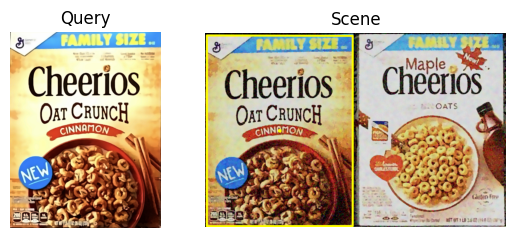

Instance 2 found in scene 1 in position: (1247, 533), width: 803px, height: 1049px


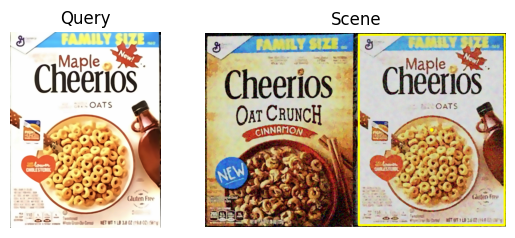

Instance 3 found in scene 2 in position: (305, 493), width: 605px, height: 942px


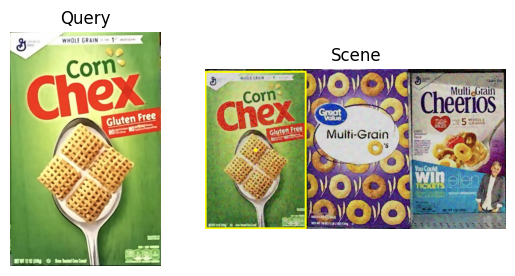

Instance 4 found in scene 2 in position: (928, 482), width: 636px, height: 951px


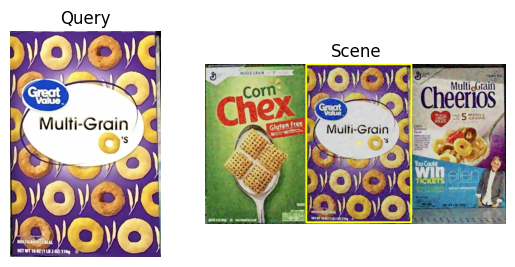

Instance 5 found in scene 2 in position: (1528, 450), width: 562px, height: 845px


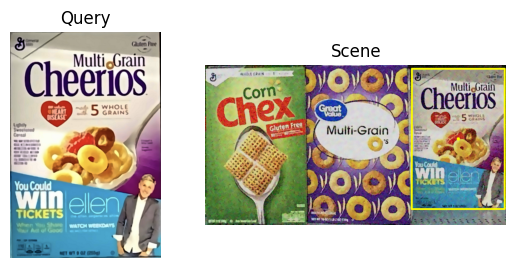

Instance 6 found in scene 3 in position: (299, 459), width: 601px, height: 672px


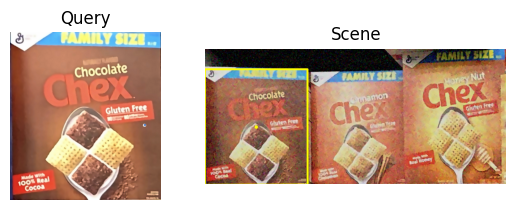

Instance 7 found in scene 3 in position: (890, 461), width: 545px, height: 652px


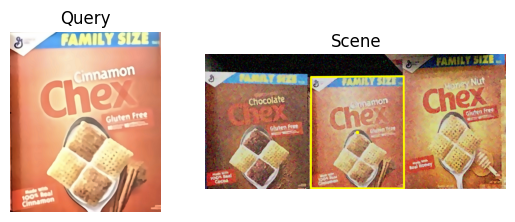

Instance 8 found in scene 3 in position: (1447, 398), width: 560px, height: 780px


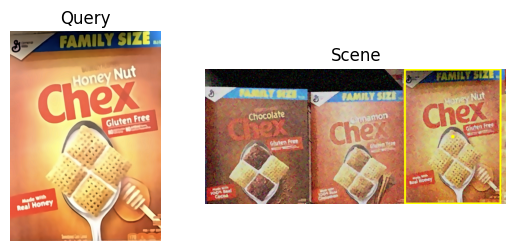

Instance 1 found in scene 4 in position: (886, 913), width: 383px, height: 516px


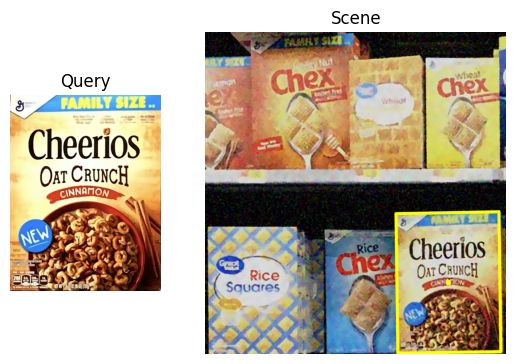

Instance 8 found in scene 4 in position: (350, 260), width: 351px, height: 496px


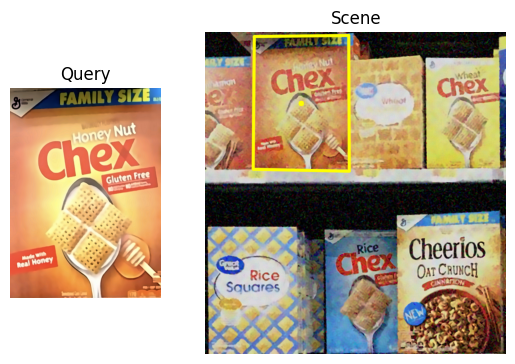

Instance 9 found in scene 4 in position: (174, 942), width: 329px, height: 467px


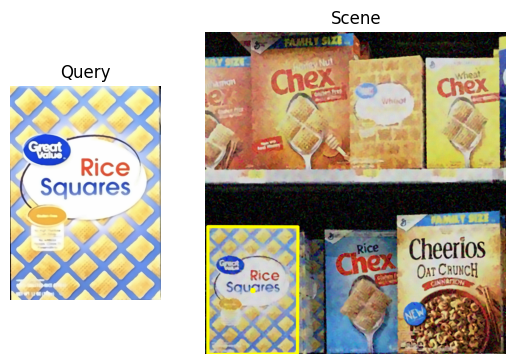

Instance 10 found in scene 4 in position: (936, 295), width: 273px, height: 406px


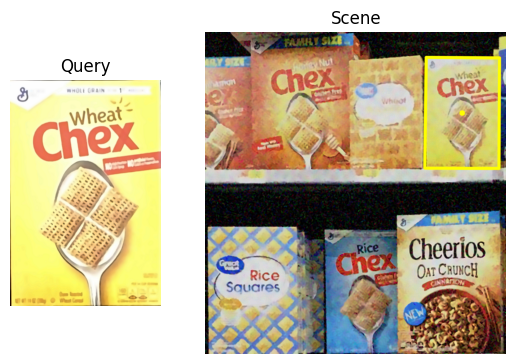

Instance 11 found in scene 5 in position: (367, 749), width: 371px, height: 556px


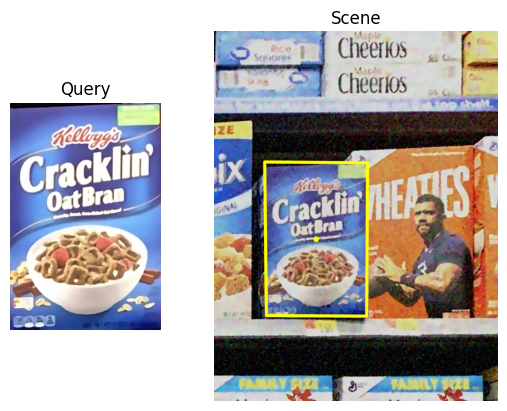

Instance 12 found in scene 5 in position: (716, 737), width: 440px, height: 655px


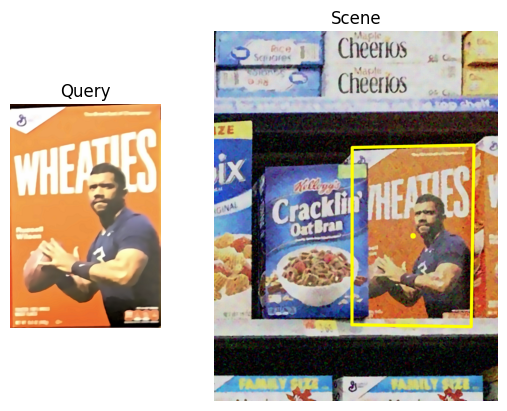

In [ ]:
for i, path in enumerate(imgs_train):
    img_train = cv2.imread(path)
    img_train = denoise_image(img_train)
    for j, img_query in enumerate(img_query_filtered):
        found = object_retrieve_track_a(img_query, img_train, 50, i + 1, j + 1)

#TrackB

Our approach to solve this problem for every query was:

**Step 1.** Find a first possible instance like in Track A using SIFT and Flann, comparing the number of good matches with a threshold, and then also comparing the color similarity.  

**Step 2.** Remove the keypoints in the ROI found as a posible instance even if an instance wasn't found. Save the new train keypoints.

**Step3.** Repeat with the new keypoints until the number of good matches is lower than 10.

With this we managed to identify ***28/31*** instances.  

We also got 17 false positives, this is because the instances were very similar to each other, the biggest difference between them being the color. We managed to filter out some false positives using the color similarity approach, but it wasn't as effective because the salt-and-pepper noise was colored making the method much more ineffective.  

Another cause for the large number of false positives is the low thresholds we chose. If we increased those values we could have avoided this problem, but it would have greatly decreased the number of instances we found. In the end we settled for this result.

In [ ]:
imgs_train_2 = []
imgs_model_2 = []
for i in range(15, 28):
    imgs_model_2.append("/content/dataset/models/ref"+str(i)+".png")
for i in range(6, 13):
    imgs_train_2.append("/content/dataset/scenes/scene"+str(i)+".png")

In [ ]:
# Denoise and save the denoised query images to optimize the pipeline and
# not denoise the same image multiple times while going through each scene
img_query_filtered = []
for path_model in imgs_model_2:
  img_query = cv2.imread(path_model)
  img_query = denoise_image(img_query)
  img_query_filtered.append(img_query)

In [ ]:
def draw_lines_track_b(kp_query, kp_train, img_query, img_train, good, instances):
    # Build the correspondences arrays of good matches
    src_pts = np.float32([kp_query[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Estimate a robust homography using RANSAC
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Corners of the query image
    h, w = img_query.shape[:2]
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts, M)

    # Extracting the bounding box
    coordinate = np.int32(dst).reshape(-1, 2)
    x, y, w, h = cv2.boundingRect(coordinate)

    # Extract the ROI from the train image
    roi_train = img_train[y:y+h, x:x+w]
    if roi_train.size == 0:
        return [], set()


    # Extract the indices of the keypoints in the scene in the ROI
    roi_indices = set()
    for i, kp in enumerate(kp_train):
        x_kp, y_kp = kp.pt
        if x <= x_kp < x + w and y <= y_kp < y + h:
            roi_indices.add(i)

    height, width, channels = img_train.shape
    if(h > height or x < 0 or y < 0):
        return [], roi_indices

    hist_threshold = 0.1

    # Compare histograms using correlation
    hist_query = compute_color_histogram(img_query)
    hist_train_roi = compute_color_histogram(roi_train)
    similarity = cv2.compareHist(hist_query, hist_train_roi, cv2.HISTCMP_CORREL)
    if similarity < hist_threshold:
        return [], roi_indices

    # Drawing the bounding box
    img_train = cv2.polylines(img_train, [coordinate], True, (255, 0, 0), 10, cv2.LINE_AA)
    img_train = cv2.circle(img_train, (x + w // 2, y + h // 2), 10, (255, 0, 0), -1)

    instance = {
        "width" : w,
        "height" : h,
        "x" : x,
        "y": y
    }

    instances.append(instance)
    return img_train, roi_indices

In [ ]:
def lowe_ratio_test_track_b(matches, min_match_count, kp_query, kp_train, img_query, img_train, instances):
    good = []

    # Collect the good matches by performing the lowe ratio test
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    if len(good)>min_match_count:
        train_img, good_kp = draw_lines_track_b(kp_query, kp_train, img_query, img_train, good, instances)
        if(len(train_img) == 0):
          return -1, good_kp
        return len(good), good_kp
    else:
        return -1, set()

In [ ]:
def object_retrieve_track_b(img_query, img_train, min_match_count, instances, kp_train = []):

    # If no keypoints are given compute keypoints for scene
    if len(kp_train) == 0:
      kp_train = sift.detect(img_train)

    # Sift and detect for query and scene
    kp_query = sift.detect(img_query)
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train, kp_train)

    matches = flann.knnMatch(des_query,des_train,k=2)
    found, good = lowe_ratio_test_track_b(matches, min_match_count, kp_query, kp_train, img_query, img_train, instances)

    # Create a set of all indices in kp_train
    all_train_indices = set(range(len(kp_train)))

    # Subtract matched_train_indices (good) from all_train_indices
    unmatched_train_indices = all_train_indices - good

    # Retrieve the keypoints corresponding to the remaining indices
    unmatched_keypoints = [kp_train[i] for i in unmatched_train_indices]

    return found, unmatched_keypoints, good

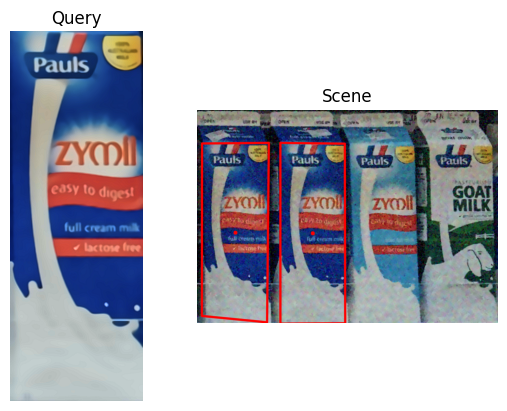

Product 15 - 2 instance found:
  Instance 0  [position: (419, 165), width: 327px, height: 911px]
  Instance 1  [position: (24, 165), width: 338px, height: 904px]


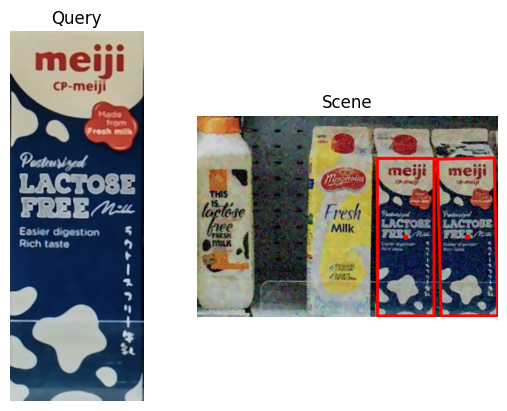

Product 16 - 2 instance found:
  Instance 0  [position: (915, 159), width: 231px, height: 604px]
  Instance 1  [position: (686, 161), width: 217px, height: 602px]


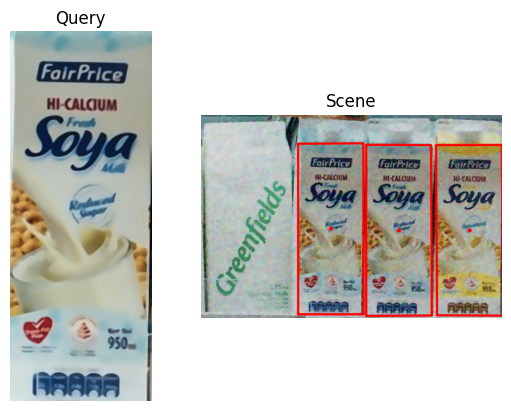

Product 17 - 3 instance found:
  Instance 0  [position: (485, 141), width: 328px, height: 855px]
  Instance 1  [position: (825, 148), width: 329px, height: 856px]
  Instance 2  [position: (1174, 149), width: 336px, height: 854px]


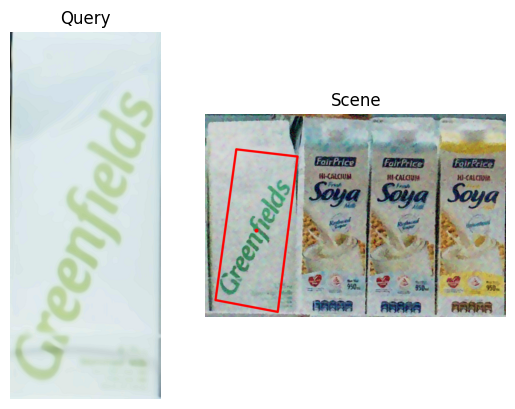

Product 18 - 1 instance found:
  Instance 0  [position: (52, 176), width: 411px, height: 813px]


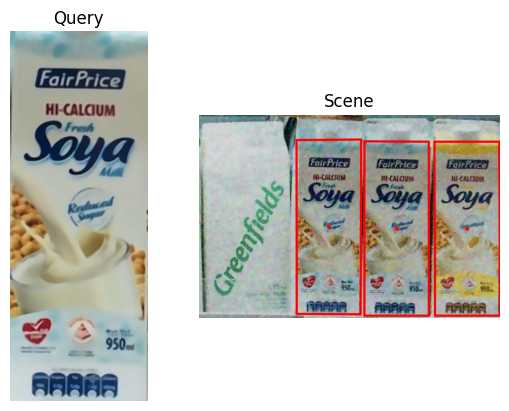

Product 23 - 3 instance found:
  Instance 0  [position: (826, 131), width: 323px, height: 872px]
  Instance 1  [position: (487, 122), width: 324px, height: 874px]
  Instance 2  [position: (1176, 133), width: 329px, height: 870px]


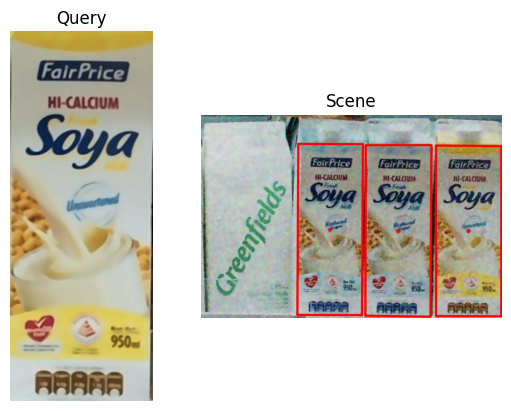

Product 24 - 3 instance found:
  Instance 0  [position: (1174, 152), width: 327px, height: 854px]
  Instance 1  [position: (821, 150), width: 331px, height: 858px]
  Instance 2  [position: (481, 144), width: 329px, height: 856px]


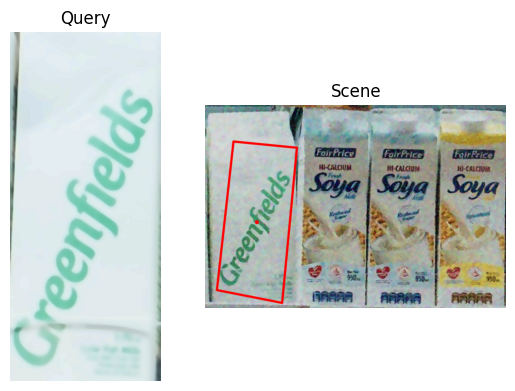

Product 27 - 1 instance found:
  Instance 0  [position: (59, 182), width: 401px, height: 807px]


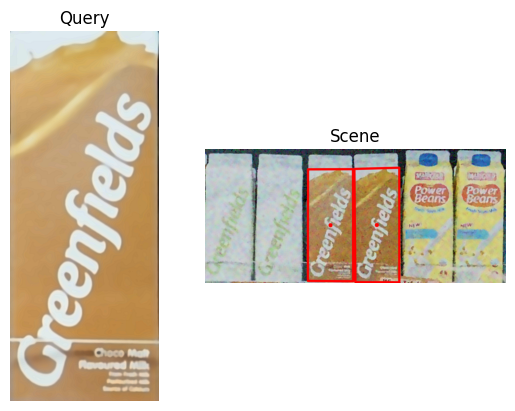

Product 19 - 2 instance found:
  Instance 0  [position: (508, 99), width: 225px, height: 555px]
  Instance 1  [position: (738, 92), width: 223px, height: 567px]


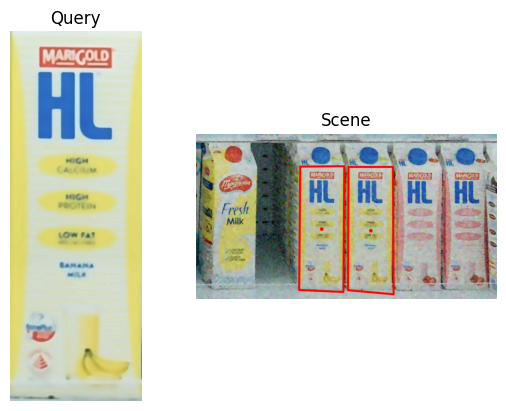

Product 21 - 2 instance found:
  Instance 0  [position: (856, 190), width: 258px, height: 716px]
  Instance 1  [position: (581, 186), width: 255px, height: 707px]


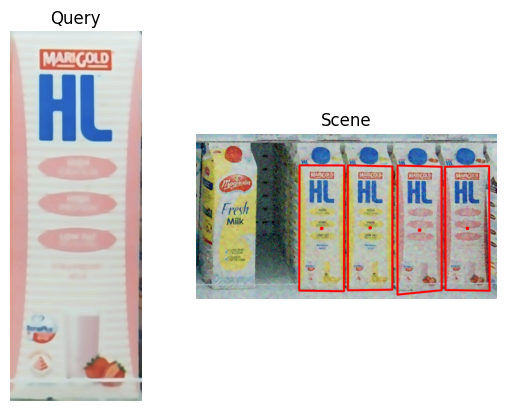

Product 22 - 4 instance found:
  Instance 0  [position: (1403, 185), width: 252px, height: 701px]
  Instance 1  [position: (1135, 182), width: 250px, height: 726px]
  Instance 2  [position: (581, 181), width: 255px, height: 708px]
  Instance 3  [position: (855, 181), width: 252px, height: 703px]


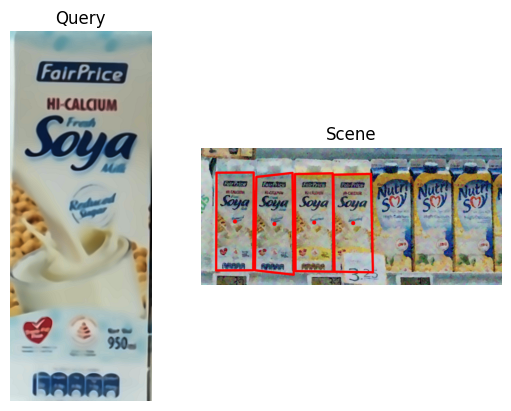

Product 17 - 4 instance found:
  Instance 0  [position: (74, 120), width: 186px, height: 483px]
  Instance 1  [position: (265, 122), width: 192px, height: 502px]
  Instance 2  [position: (651, 127), width: 196px, height: 485px]
  Instance 3  [position: (462, 124), width: 191px, height: 485px]


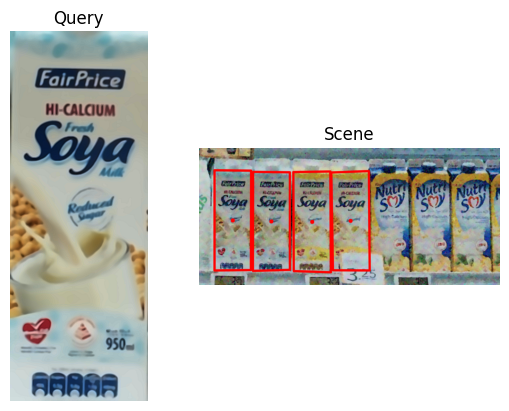

Product 23 - 4 instance found:
  Instance 0  [position: (651, 113), width: 190px, height: 490px]
  Instance 1  [position: (265, 117), width: 183px, height: 488px]
  Instance 2  [position: (76, 109), width: 181px, height: 494px]
  Instance 3  [position: (464, 115), width: 186px, height: 497px]


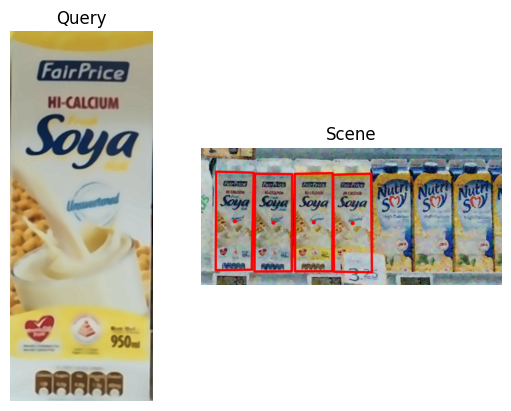

Product 24 - 4 instance found:
  Instance 0  [position: (461, 123), width: 188px, height: 484px]
  Instance 1  [position: (650, 126), width: 192px, height: 486px]
  Instance 2  [position: (263, 126), width: 186px, height: 482px]
  Instance 3  [position: (72, 116), width: 188px, height: 486px]


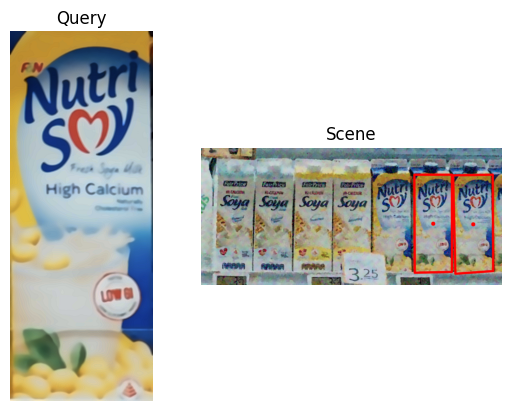

Product 25 - 2 instance found:
  Instance 0  [position: (1050, 131), width: 186px, height: 483px]
  Instance 1  [position: (1241, 131), width: 198px, height: 488px]


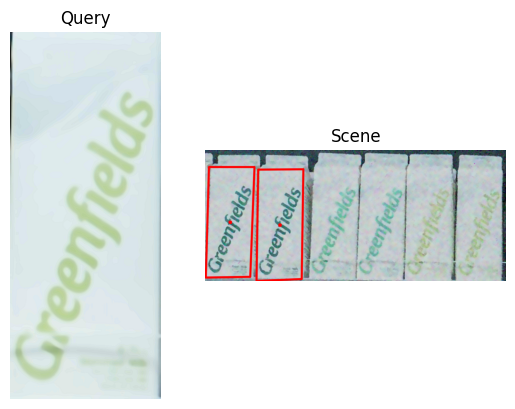

Product 18 - 2 instance found:
  Instance 0  [position: (278, 103), width: 254px, height: 601px]
  Instance 1  [position: (4, 91), width: 264px, height: 595px]


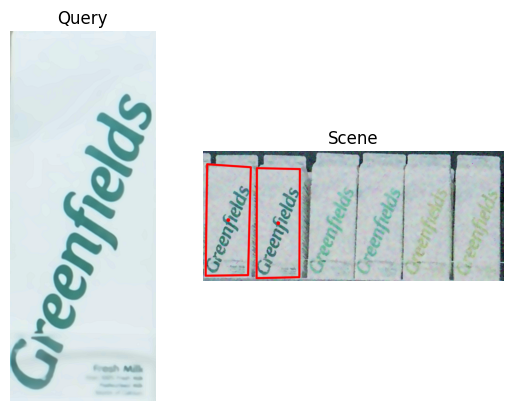

Product 26 - 2 instance found:
  Instance 0  [position: (289, 97), width: 235px, height: 592px]
  Instance 1  [position: (14, 76), width: 245px, height: 600px]


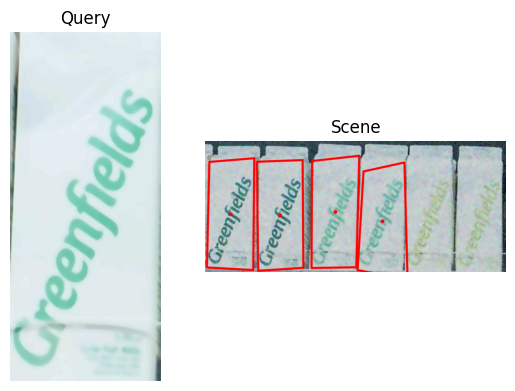

Product 27 - 4 instance found:
  Instance 0  [position: (10, 92), width: 257px, height: 602px]
  Instance 1  [position: (280, 102), width: 252px, height: 596px]
  Instance 2  [position: (575, 79), width: 259px, height: 604px]
  Instance 3  [position: (824, 115), width: 271px, height: 632px]


In [ ]:
for path in imgs_train_2:
    img_train_original = cv2.imread(path)
    img_train_original = denoise_image(img_train_original)

    # Index for object
    j = 15
    for path_model in imgs_model_2:
        img_query = cv2.imread(path_model)
        img_query = denoise_image(img_query)

        img_train = img_train_original.copy()

        kp_train = []
        instances = []

        found, kp_train, good = object_retrieve_track_b(img_query, img_train, 12, instances, kp_train)

        # While the number of matches is higher than 10 still look for instances even though no instance found in the previous run
        while(len(good) > 10):
          found, kp_train, good = object_retrieve_track_b(img_query, img_train, 12, instances, kp_train)

        if(len(instances) > 0):
            fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]})
            axes[0].imshow(img_query)
            axes[0].axis('off')  # Turn off axis
            axes[0].set_title('Query')

            axes[1].imshow(img_train)
            axes[1].axis('off')  # Turn off axis
            axes[1].set_title('Scene')
            plt.show()

            print("Product {} - {} instance found:".format(j, len(instances)))
            for i, instance in enumerate(instances):
                print("  Instance {}  [position: ({}, {}), width: {}px, height: {}px]". format(i, instance['x'], instance['y'], instance['width'], instance['height']))

        j += 1